In [18]:
pip install keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install coremltools

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
from scipy import stats

In [2]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout, Flatten, Reshape, Conv1D, MaxPooling1D, BatchNormalization, AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

2023-07-19 13:32:48.847573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 13:32:53.866921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format # result data will be float with 1 decimal point
sns.set() # Default seaborn look and feel
plt.style.use('ggplot') # set plotting style
print('keras version ', keras.__version__)

# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

keras version  2.12.0


In [ ]:
'''Use this set of labels to train all 6 activities'''
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

In [4]:
'''Use this set of labels to train Binary classification (active and non-active activities)'''
LABELS = ['Active',
          'Non-active']

In [4]:
'''Use this set of labels to train Active activity classification only (Walking, Jogging, Downstairs, Upstairs)'''
LABELS = ['Downstairs',
          'Jogging',
          'Upstairs',
          'Walking']

In [5]:
'''Use this set of labels to train Non-Active activity classification only (Sitting, Standing)'''
LABELS = ['Sitting',
          'Standing']

In [9]:
# create functions to read data and show information
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    # import data set: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
    df = pd.read_csv(file_path,
                     header=None,                 # column names are passed explicitly so header = none
                     names=column_names,          #List of column names to use
                     lineterminator = ';',        #lineterminator: break file into lines
                     skiprows = [343419] )        # rows 343419 has unknown error when trying to run so skip it to avoid error
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,              # If this is true -> to_replace must be string (default = false). What is regex??
      inplace=True,                               # Whether to modify the DataFrame rather than creating a new one.Default is false
      to_replace=r';',                            #find value that will be replaced
      value=r'')                                  # replace with this value ''
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0,                             # determine rows or column to removed (0 = rows, 1 = column)
              how='any',                          # Determine if row or column is removed from DataFrame, when we have at least one NA or all NA. (Any = if one NA value present, drop that row or column)
              inplace=True)                       # Whether to modify the DataFrame rather than creating a new one (true = modified)

    return df

#function to convert string column to float
def convert_to_float(x):

    try:                                          # used to check some code for errors i.e the code inside the try block will execute when there is no error in the program.
        return np.float(x)
    except:                                       # execute whenever the program encounters some error in the preceding try block (ref: https://www.geeksforgeeks.org/python-try-except/)
        return np.nan
 
def show_basic_dataframe_info(dataframe):
    print(dataframe.shape)
    
    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))     # .shape[1] = output is no. of column. 
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))      # .shape[0] = output is no. of rows                                                                                


In [4]:
'''use this script when train only data from WISDM dataset'''
# Load data set containing all the data from csv
df = read_data('../Data/Raw_WISDM_UCI(laying).txt') 

/tmp/ipykernel_16274/3580459733.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


In [ ]:
''' use this when want to combine WISDM + UCI (Laying)'''
# Read the contents of the first text file
with open('../Data/WISDM_ar_v1.1_raw.txt', 'r') as WISDM_file:
    content1 = WISDM_file.read()

# Read the contents of the second text file
with open('../NHANES/UCI_processed_data (20 Hz).txt', 'r') as UCI_file:
    content2 = UCI_file.read()

# Combine the contents of both files
combined_content = content1 + content2

# Load data set containing all the data from csv
df = read_data('../Data/WISDM_ar_v1.1_raw.txt') 

In [5]:
# show data
show_basic_dataframe_info(df)
df.head(20)                         # .head(n) will return data from index 0 to 19
                                    # .tail(n) will return data from bottom rows to specified amount you want

# parameter to get information in form of table  
# df.info() 


(1098207, 6)
Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098207



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
5,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526
6,33,Jogging,49106542312000,-0.612916,10.569390,5.706926
7,33,Jogging,49106652389000,-0.503953,13.947236,7.055340
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871
9,33,Jogging,49106872299000,0.953424,1.375655,1.648062


In [8]:
'''Use this script when want to convert activities to Binary classification (active and non-active activities)'''
df['activity'] = df['activity'].apply(lambda x: 'Active' if (x == 'Upstairs' or x == 'Downstairs' or x == 'Walking' or x == 'Jogging') else x )
df['activity'] = df['activity'].apply(lambda x: 'Non-active' if (x == 'Sitting' or x == 'Standing') else x )

# Print the updated DataFrame
show_basic_dataframe_info(df)
df.head(20)

(1152954, 5)
Number of columns in the dataframe: 5
Number of rows in the dataframe: 1152954



,user-id,x-axis,y-axis,z-axis,activity
1152934,37,0.0,0.8,0.6,Non-active
1152935,37,0.0,0.8,0.6,Non-active
1152936,37,0.0,0.8,0.6,Non-active
1152937,37,0.0,0.8,0.6,Non-active
1152938,37,0.0,0.8,0.6,Non-active
1152939,37,0.0,0.8,0.6,Non-active
1152940,37,0.0,0.8,0.6,Non-active
1152941,37,0.0,0.8,0.6,Non-active
1152942,37,0.0,0.8,0.6,Non-active
1152943,37,0.0,0.8,0.6,Non-active


In [8]:
'''Use this script when want to train only Active activity'''
# Drop rows with non-active activity 'Sitting, Standing' in the 'activity' column
df = df.drop(df[df['activity'] == 'Sitting'].index)
df = df.drop(df[df['activity'] == 'Standing'].index)

# Print the updated DataFrame
show_basic_dataframe_info(df)
df.head(20)

(989873, 6)
Number of columns in the dataframe: 6
Number of rows in the dataframe: 989873



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


In [12]:
'''Use this script when want to train only Non-Active activity'''
# Drop rows with active activity in the 'activity' column
df = df.drop(df[df['activity'] == 'Upstairs'].index)
df = df.drop(df[df['activity'] == 'Downstairs'].index)
df = df.drop(df[df['activity'] == 'Walking'].index)
df = df.drop(df[df['activity'] == 'Jogging'].index)

# Print the updated DataFrame
show_basic_dataframe_info(df)
df.head(20)

(108334, 6)
Number of columns in the dataframe: 6
Number of rows in the dataframe: 108334



,user-id,activity,timestamp,x-axis,y-axis,z-axis
221335,27,Sitting,12363992261000,2.6,9.7,1.0
221336,27,Sitting,12364042279000,2.7,9.5,0.5
221337,27,Sitting,12364092267000,3.5,8.9,0.8
221338,27,Sitting,12364142316000,3.6,9.4,0.9
221339,27,Sitting,12364192273000,2.9,9.3,1.0
221340,27,Sitting,12364242292000,3.1,9.4,0.9
221341,27,Sitting,12364292249000,3.1,9.5,0.8
221342,27,Sitting,12364342267000,2.9,9.7,0.8
221343,27,Sitting,12364392285000,3.2,9.4,0.9
221344,27,Sitting,12364442273000,3.1,9.4,0.8


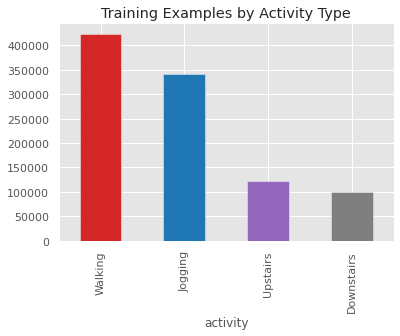

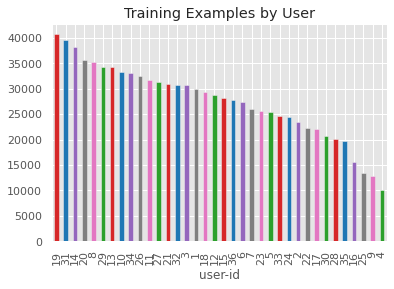

In [9]:
# Show how many training examples exist for each of the six activities
bar_colors = ['tab:red', 'tab:blue', 'tab:purple', 'tab:gray', 'tab:pink', 'tab:green'] # change bar color
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type',
                                   color = bar_colors)

plt.show()

# Better understand how the recordings are spread across the different users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User',
                                  color = bar_colors)
plt.show()

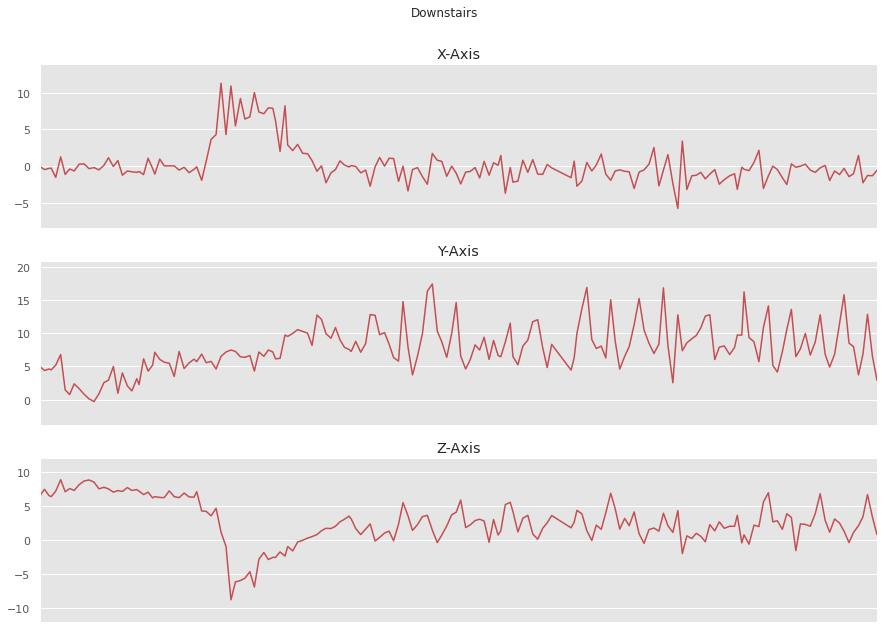

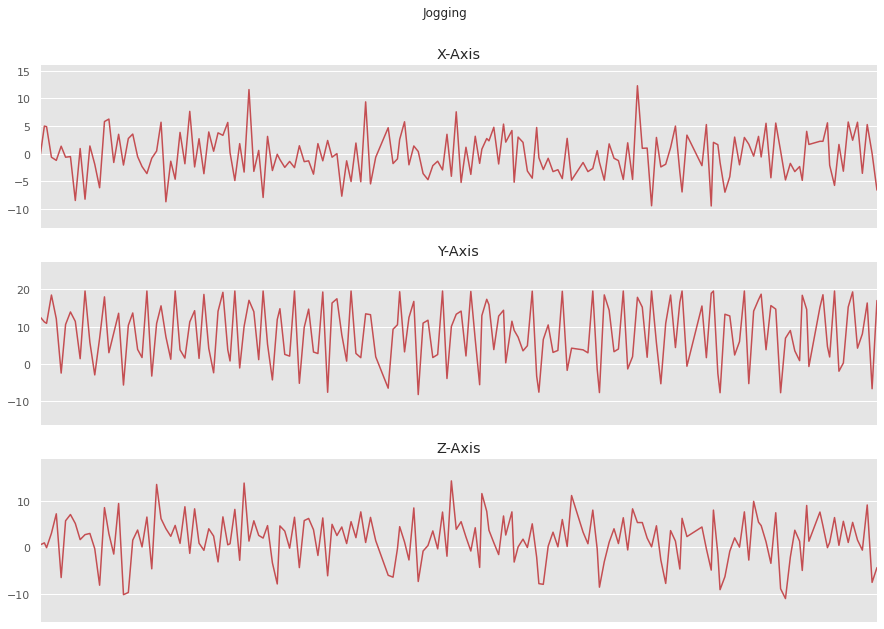

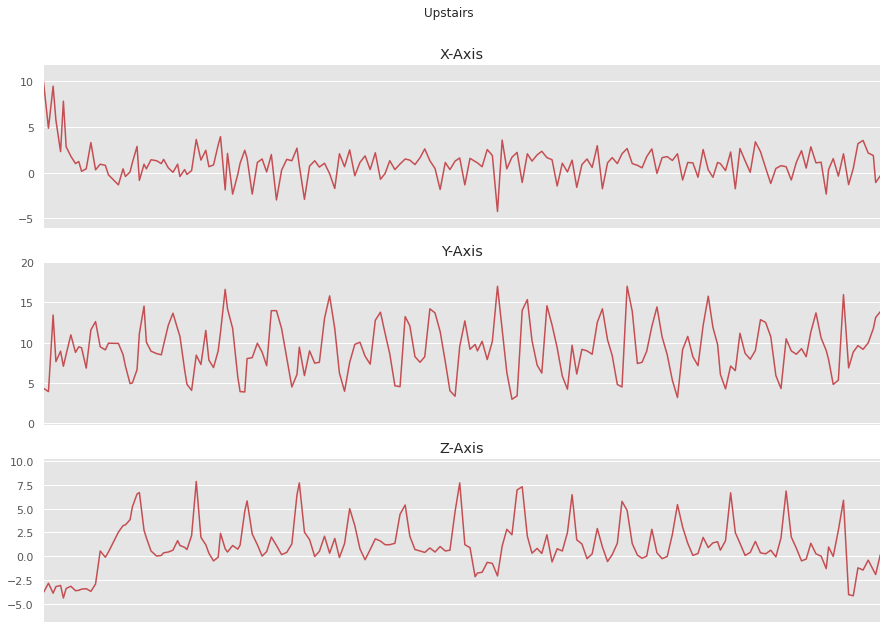

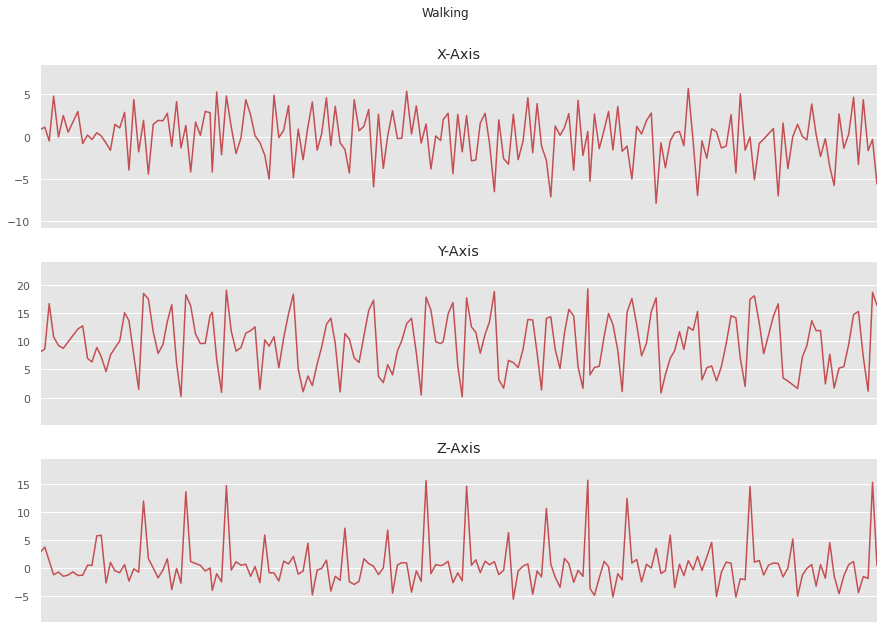

In [10]:
# Next, let’s take a look at the accelerometer data for each of the three axis for all six possible activities. 
#The data is recorded at a sampling rate of 20 Hz (20 values per second). 
#Since we show the first 180 records, each chart shows a 9 second interval for each of the six activities (calculation: 0.05 * 180 = 9 seconds). 
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,                    # .subplots() unpack this tuple into the variables fig and ax but return a tuple with two elements (figure object and a group of objects)  
         figsize=(15, 10),                                          # nrows = Number of rows/columns of the subplot grid.We want three row pf plots for x,y,z
         sharex=True)                                               # False or 'none': each subplot x- or y-axis will be independent
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')     # call function plot_axis 
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90) 
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):                         #np.unique() use to find the unique elements of an array & Returns the sorted unique elements of an array. 
    subset = df[df['activity'] == activity][:180]                  #[:180] = show first 180 records
    plot_activity(activity, subset)

In [11]:
# add 1 more column name "activityencoded" to convert each activity into nummerical labels since deep neural network cannot work with non-numerical labels.
# Define column name of the label vector
LABEL = 'ActivityEncoded'

# Transform the labels from String to Integer via LabelEncoder 
# class from scikit-learn used for converting categorizable variable into integer for algorithm that require numerical input data
le = preprocessing.LabelEncoder()          

# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel()) 
# .fit_transform() fits the encoder to data and transform data into numerical labels
# .values() returns a view object contains values as a list.
#.ravel() functions returns contiguous flattened array(1D array with all the input-array elements and with the same type as it)

In [13]:
''' Caution: Adjust number of user-id case by case basis to make train set ~80%'''
# Split between test set and training set
print('Total user-id:' ,df['user-id'].max()) # just want to know number of user id
df_test = df[df['user-id'] > 28]     # the rest will be test set (~20%)
df_train = df[df['user-id'] <= 28]   #first n user id will be training set (~80%)
print('No. of test dataset:', df_test.shape)
print('No. of train dataset:', df_train.shape)

Total user-id: 36
No. of test dataset: (230479, 7)
No. of train dataset: (759394, 7)


In [14]:
# Why need to normalized? = prepare data consistency when each colume might have large difference in numbers. https://learn.microsoft.com/en-us/azure/machine-learning/component-reference/normalize-data
# Next, Normalize our features within our training data. (values between 0 and 1)
# *use the same normalization algorithm later when feeding new data into your neural network. Otherwise your preditions will be off*

# Surpress warning for next 3 operation
def max_scale_round(df):
    pd.options.mode.chained_assignment = None  # allow to modify the DataFrame or Series using chained indexing without generating a warning. default='warn', none will ignore the warning
    df['x-axis'] = df['x-axis'] / df['x-axis'].max()
    df['y-axis'] = df['y-axis'] / df['y-axis'].max()
    df['z-axis'] = df['z-axis'] / df['z-axis'].max()
    # Round numbers
    df = df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})      #apply rounding to 4 decimal places for the three features (x,y,z) https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.round.html 
    return df

df_train = max_scale_round(df_train)
df_test = max_scale_round(df_test)

In [15]:
# reshape data into segments using another function
# This function will take in the dataframe and the label names 
#(the constant that we have defined at the beginning) as well as the length of each record. 
#In our case, let’s go with 80 steps.
# function will also separate the features (x-acceleration, y-acceleration, z-acceleration) and the labels (associated activity).

def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):     #obtain value in each axis from each segments
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
        #print(segments)
        #print(labels)
    # Bring the segments into a better shape
    # np.asarray() create new numpy array from 'segments' list with all elements convert to 'float32' data type
    # .reshaped() reshapes the newly created numpy array into a 3D array with time_steps time steps and N_FEATURES features per time step
    # -1 is inferred by numpy and depends on the size of the original array and the given number of time steps and features. It is used to automatically determine the size of the first dimension to ensure that the reshape operation does not lose any data.
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    print(reshaped_segments)
    labels = np.asarray(labels)

    return reshaped_segments, labels

# x_train = feature data
# y_train = label data (already in number from 1-6)
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)
x_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

[[[ 0.0287 -0.     -0.0116]
  [ 0.0075  0.0075  0.0307]
  [ 0.0055 -0.0055 -0.0041]
  ...
  [-0.1681  0.016  -0.1014]
  [-0.0118 -0.0917 -0.1229]
  [-0.0118  0.0507  0.2542]]

 [[ 0.0731  0.0771  0.1208]
  [ 0.1898  0.1284  0.0771]
  [ 0.0867  0.0423  0.0041]
  ...
  [-0.2111 -0.0549 -0.1445]
  [-0.0333  0.0271 -0.2049]
  [-0.0313 -0.0583  0.2737]]

 [[ 0.1017  0.1208 -0.0403]
  [ 0.1208  0.2765  0.1495]
  [ 0.0519  0.0922  0.0382]
  ...
  [-0.2091 -0.0076  0.0097]
  [-0.0174 -0.0917 -0.0465]
  [-0.0118  0.1292  0.3577]]

 ...

 [[ 0.411   0.4416 -0.1709]
  [-0.2436 -0.2997 -0.388 ]
  [-0.4767 -0.6812 -0.8221]
  ...
  [ 0.1091 -0.0551 -0.2147]
  [ 0.154   0.5079  0.178 ]
  [-0.2208 -0.1076  0.1112]]

 [[ 0.1559 -0.1609 -0.1228]
  [ 0.1248  0.1749 -0.1805]
  [-0.3825 -0.5454 -0.4396]
  ...
  [ 0.0408  0.0571 -0.0076]
  [-0.0214 -0.1305 -0.2616]
  [-0.1346  0.0959  0.1249]]

 [[ 0.015  -0.1825 -0.3208]
  [-0.4897 -0.6917 -0.0306]
  [-0.0977 -0.3338 -0.4436]
  ...
  [ 0.0571 -0.2402  0.00

In [16]:
# By now, you should have both 20.868 records in x_train as well as in y_train. 
# Each of the 20.868 records in x_train is a two dimensional matrix of the shape 80x3.
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)  


x_train shape:  (18983, 80, 3)
18983 training samples
y_train shape:  (18983,)


In [17]:
# Set input & output dimensions in Deep neural network
# num time period = 80, num sensors = 3 (x,y,z axis)
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
# Number of classes: This is the amount of nodes for our output layer in the neural network. 
num_classes = le.classes_.size 
# property of LabelEncoder(): returns the number of unique categories in the input data that were encoded
# '.classes_ 'returns a sorted array of the unique categories in the input data
# '.size' property returns the length of this array
print(list(le.classes_))

['Downstairs', 'Jogging', 'Upstairs', 'Walking']


In [19]:
# convert 2D data (80x3) into a list of 240 values since Keras and Core ML cannot be used with multi-dimensional input data.
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape) # reshape x_train array into 1D by slicing 20868 samples into various lists containing 240 elements
x_test = x_test.reshape(x_test.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)
print('x_test shape:', x_test.shape)

x_train shape: (18983, 240)
input_shape: 240
x_test shape: (5760, 240)


In [20]:
# convert all feature data (x_train) and label data (y_train) into a datatype accepted by Keras.
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [21]:
# perform onehotencoder to convert labels into binary vector (numerical value: in this case 0 to 5 since we have 6 types of activity/labels)
# use to_categorical() function from the keras.utils module to perform one-hot encoding. It takes 2 arguments: 1.catergorical data 2. total num of categories
# also transformed the original array of integer labels into a 2D NumPy array of binary vectors, with one vector for each label.

y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)
y_test_hot = np_utils.to_categorical(y_test, num_classes)
print('New y_test shape: ', y_test_hot.shape)

New y_train shape:  (18983, 4)
New y_test shape:  (5760, 4)


In [22]:
conv_model = Sequential()
conv_model.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))   #reshape data from 240 to 80x3 
conv_model.add(Conv1D(filters=32,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(Conv1D(filters=32,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(MaxPooling1D(pool_size = 2))
conv_model.add(Conv1D(filters=64,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(Conv1D(filters=64,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(MaxPooling1D(pool_size = 2))
conv_model.add(Conv1D(filters=128,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(Conv1D(filters=128,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(MaxPooling1D(pool_size = 2))
conv_model.add(Conv1D(filters=256,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(Conv1D(filters=256,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(MaxPooling1D(pool_size = 2))
conv_model.add(Flatten())
conv_model.add(Dense(24, activation='relu'))
conv_model.add(Dense(24, activation='relu'))
conv_model.add(Dense(24, activation='relu'))
conv_model.add(Dense(num_classes, activation='softmax'))                    # The softmax activation function is commonly used in the output layer of a classification neural network. It converts the output of the previous layer to a probability distribution over the classes. The output values from the softmax function sum to 1, and each value represents the probability that the input belongs to a specific class.
print(conv_model.summary())

2023-07-10 00:08:04.899794: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 80, 3)             0         
                                                                 
 conv1d (Conv1D)             (None, 78, 32)            320       
                                                                 
 batch_normalization (BatchN  (None, 78, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 76, 32)            3104      
                                                                 
 batch_normalization_1 (Batc  (None, 76, 32)           128       
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 32)           0

In [23]:
''' Caution: need to change name of saved checkpoints everytime '''
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='CNN_active_model_1.{epoch:02d}-{val_loss:.2f}.h5',   #change to 1D convolutional network
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

conv_model.compile(loss='categorical_crossentropy', 
                   optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
                   metrics=['accuracy'])

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = conv_model.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
38/38 [==============================] - 4s 63ms/step - loss: 0.5363 - accuracy: 0.7801 - val_loss: 1.4924 - val_accuracy: 0.0693
Epoch 2/50
38/38 [==============================] - 2s 42ms/step - loss: 0.1916 - accuracy: 0.9308 - val_loss: 2.2669 - val_accuracy: 0.0906
Epoch 3/50
38/38 [==============================] - 2s 42ms/step - loss: 0.1065 - accuracy: 0.9648 - val_loss: 3.0622 - val_accuracy: 0.0906
Epoch 4/50
38/38 [==============================] - 2s 42ms/step - loss: 0.0659 - accuracy: 0.9782 - val_loss: 4.4091 - val_accuracy: 0.0906
Epoch 5/50
38/38 [==============================] - 2s 42ms/step - loss: 0.0465 - accuracy: 0.9843 - val_loss: 5.9428 - val_accuracy: 0.0906
Epoch 6/50
38/38 [==============================] - 2s 42ms/step - loss: 0.0336 - accuracy: 0.9883 - val_loss: 6.2816 - val_accuracy: 0.0906
Epoch 7/50
38/38 [==============================] - 2s 42ms/step - loss: 0.0289 - accuracy: 0.9912 - val_loss: 6.2189 - val_accuracy: 0.0909
Epoch 8/50
38

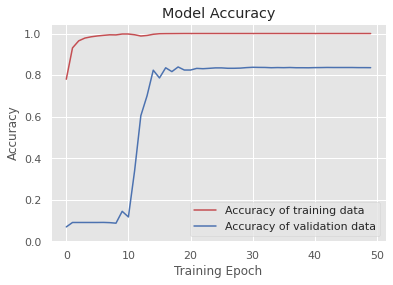

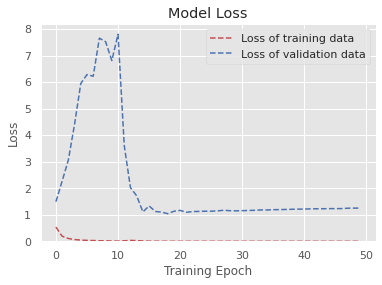

594/594 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      1860
         1.0       0.99      0.98      0.98      6567
         2.0       0.90      0.94      0.92      2344
         3.0       0.98      0.97      0.98      8212

    accuracy                           0.97     18983
   macro avg       0.95      0.96      0.95     18983
weighted avg       0.97      0.97      0.97     18983



In [24]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = conv_model.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

180/180 [==============================] - 1s 3ms/step


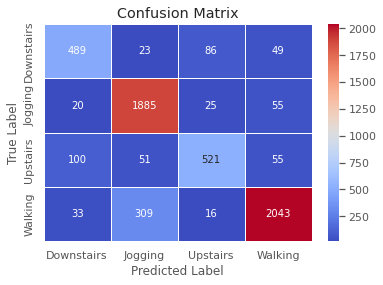

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       647
           1       0.83      0.95      0.89      1985
           2       0.80      0.72      0.76       727
           3       0.93      0.85      0.89      2401

    accuracy                           0.86      5760
   macro avg       0.83      0.82      0.82      5760
weighted avg       0.86      0.86      0.86      5760



In [25]:
def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,                
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = conv_model.predict(x_test)

# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))